In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pydot
import os
from IPython.display import SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseDynamicsController,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    RotationMatrix,
    StateInterpolatorWithDiscreteDerivative,
    ConstantVectorSource,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
)
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.scenarios import AddMultibodyTriad, MakeManipulationStation
from manipulation.meshcat_utils import AddMeshcatTriad
from pydrake.multibody import inverse_kinematics
import matplotlib.pyplot as plt
import copy
import time
from collections import Counter

In [3]:
import model_builder
import AllegroWrapper

In [4]:
meshcat, station, simulator, context = model_builder.build_scenario()
allegro = AllegroWrapper.AllegroHand(station, context)
simulator.set_target_realtime_rate(1.0)
x0 = allegro.get_state()

INFO:drake:Meshcat listening for connections at http://localhost:7000


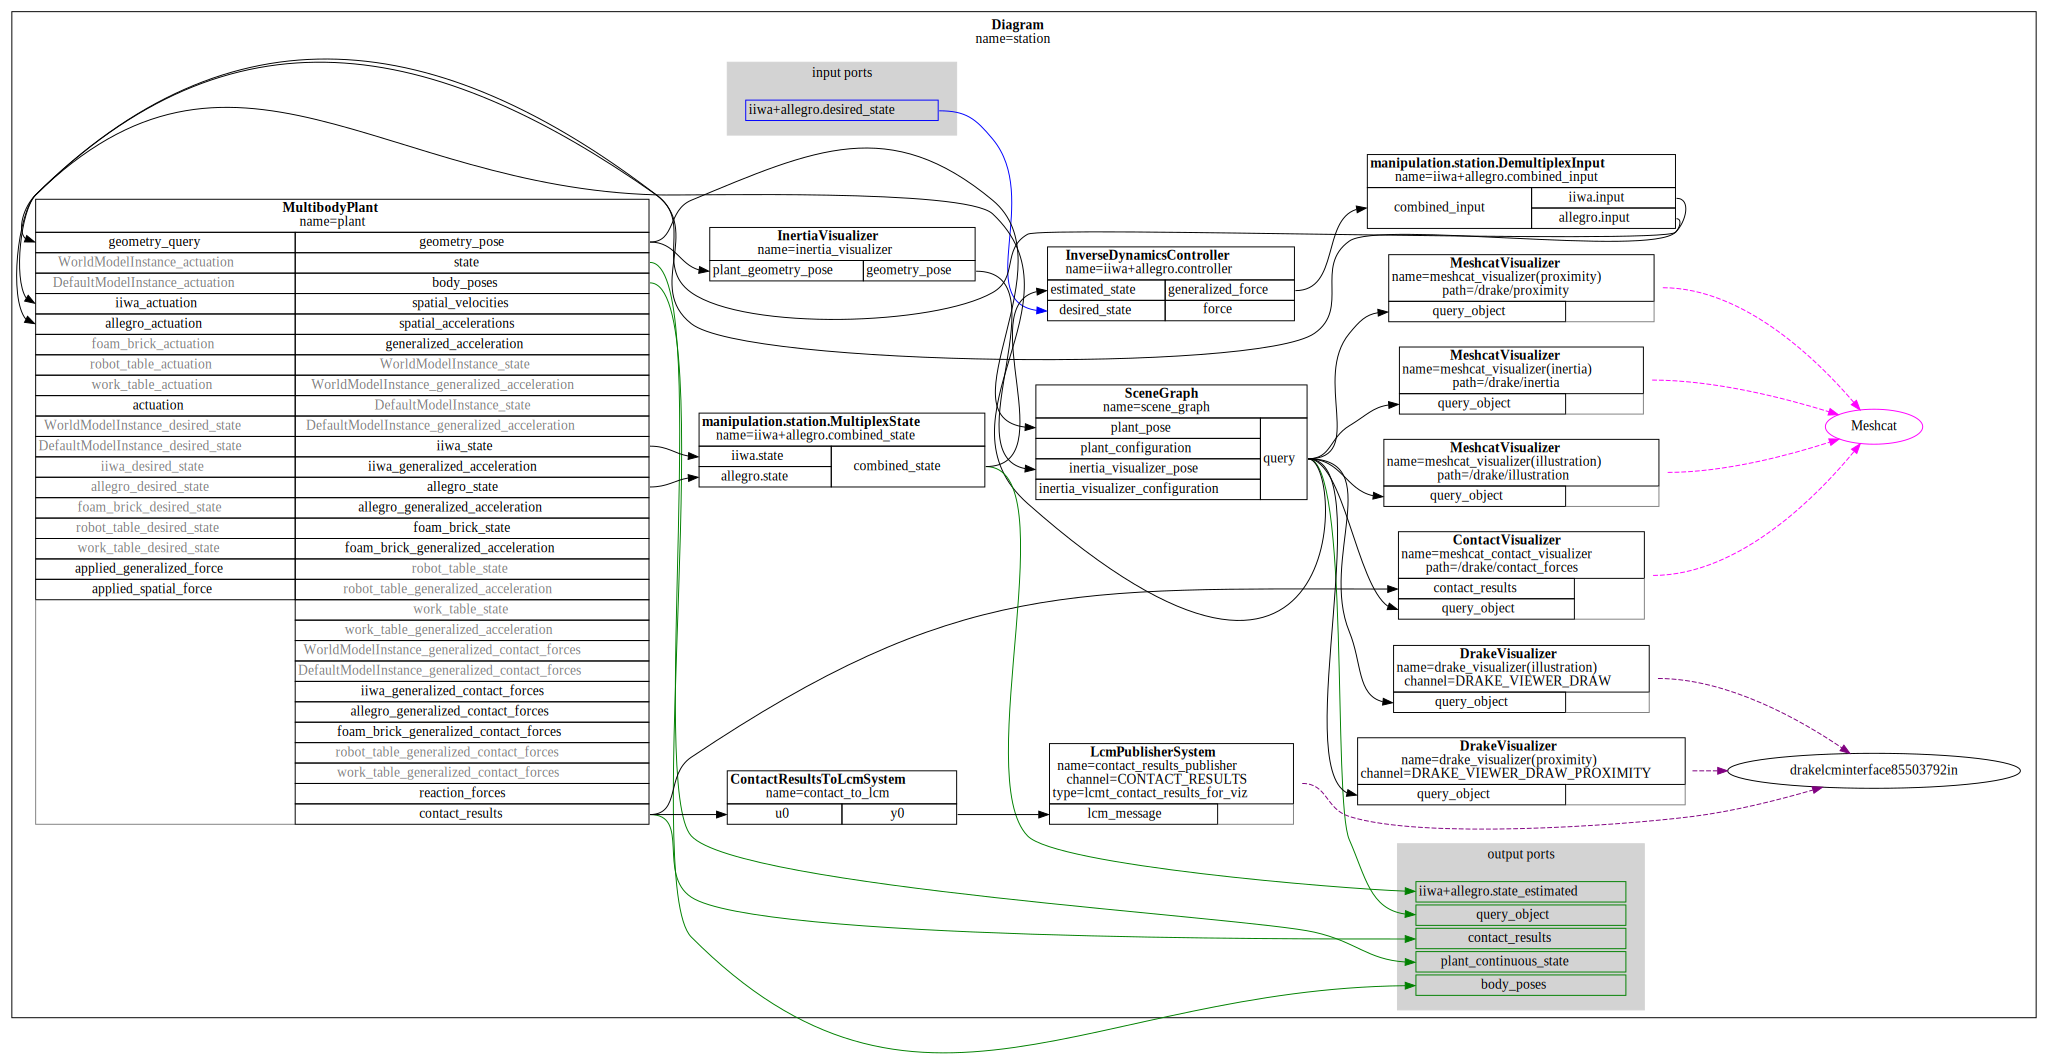

In [5]:
display(
    SVG(
        pydot.graph_from_dot_data(station.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)

In [6]:
def reset_arm():
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)
    simulator.AdvanceTo(context.get_time() + 1)

In [7]:
def normalize(v):
    return v / np.sum(v)

In [8]:
def get_table_contact(X_robot_W, final_height = -0.2, num_knot_points=10):
    """
    Moves the arm down until it comes in contact with the table
    """
    final_rotation = X_robot_W.rotation()
    initial_position = X_robot_W.translation()
    final_position = copy.deepcopy(initial_position)
    final_position[2] = final_height
    # final_position = [0.5, 0, 0]
    t_list = np.arange(num_knot_points)
    positions = np.zeros((num_knot_points, 3))
    for i in range(3):
        positions[:, i] = np.linspace(
            initial_position[i], final_position[i], num_knot_points
        )
    p_list = []
    for p in positions:
        p_list.append(RigidTransform(final_rotation, p))
    return p_list



def sample_new_target(prev_touch, p_grid, target_bias=None, xmin=0.3, xmax=0.5, ymin=-0.3, ymax=0.3, n_samples=10):
    """
        Proposes a new location to reach with the hand.
        
        Args:
            previous_targets: np.array[coords]: list of previous target locations already checked 
            target_bias: np.array: (x, y, z) location to act as a kind of bias
    """
    object_r = 0.05
    effort_ratio = 0.7
    effort_c = 2.0
    p_target_c = 2.0

    table_x_bounds = [xmin, xmax]
    table_y_bounds = [ymin, ymax]

    if len(list(p_grid.keys())) == 0:
        p_grid = {}
        for x in np.linspace(table_x_bounds[0], table_x_bounds[1], n_samples):
            for y in np.linspace(table_y_bounds[0], table_y_bounds[1], n_samples):
                p_grid[(x, y)] = 0.5

    all_p = []
    all_effort = []
    all_dist = []
    table_grid = {}
    for coord, prob in p_grid.items():
        dist = np.linalg.norm(np.array(coord) - prev_touch)
        if dist < object_r:
            p_target = 0.0
        else:
            c_dist = dist - object_r
            p_target = 1 - np.exp(-p_target_c * c_dist)
        new_p_target = prob * p_target
        if new_p_target == 0.0:
            effort_cost = 0.0
        else:
            effort_cost = np.exp(-effort_c * c_dist)
        p_grid[coord] = new_p_target
        all_effort.append(effort_cost)
        all_p.append(new_p_target)
        all_dist.append(dist)
    all_effort_norm = normalize(all_effort)
    all_p_norm = normalize(all_p)
    for i, coord in enumerate(p_grid.keys()):
        table_grid[coord] = all_p_norm[i] * (1 - effort_ratio) + all_effort_norm[i] * effort_ratio
    table_grid_norm = normalize(list(table_grid.values()))
    next_touch_idx = np.random.choice(np.arange(len(list(table_grid.keys()))), p=table_grid_norm)
    next_touch = list(p_grid.keys())[next_touch_idx]
    
    return next_touch, p_grid


def interpolate_locations(current_location, new_location, X_robot_W, interp_steps=4, arc_height=0.5):
    # NOTE: Convert positions to RigidTransforms
    """
    Linear interpolation between two 3D coordinates
    """
    coords = np.hstack([current_location, new_location])
    xs = np.linspace(current_location[0], new_location[0], interp_steps)
    ys = np.linspace(current_location[1], new_location[1], interp_steps)

    # If z-values are the same, move the arm up to avoid dragging along 
    if current_location[2] == new_location[2]:
        z0 = np.linspace(current_location[2], current_location[2] + arc_height, interp_steps // 2)
        z1 = np.linspace(current_location[2] + arc_height, new_location[2], interp_steps // 2)
        zs = np.concatenate([z0, z1])

    else:
        zs = np.linspace(current_location[2], new_location[2], interp_steps)
    
    interp_coords = np.vstack((xs, ys, zs)).T
    new_coords = np.vstack([interp_coords, new_location])

    pose_list = []
    for i in range(len(new_coords)):
        pose = RigidTransform(X_robot_W.rotation(), new_coords[i])
        pose_list.append(pose)
        
    return pose_list


def optimize_arm_movement(end_effector_poses, frame="iiwa_link_6"):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant = station.GetSubsystemByName("plant")
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName(frame)

    # iiwa_initial = robot_state[:7]
    # gripper_initial = robot_state[7:30]
    iiwa_initial = np.array([0.0, 0.1, 0.0, -1.5, 0.0, 0.0, 0.0])
    gripper_initial = np.ones((23))
    q_nominal = np.concatenate((iiwa_initial, gripper_initial))

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    for i in range(len(end_effector_poses)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        pose = end_effector_poses[i]
        AddPositionConstraint(
                    ik,
                    pose.translation(),
                    pose.translation(),
        )
    
        prog.AddQuadraticErrorCost(np.identity(len(q_variables)), q_nominal, q_variables)
        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[i-1])

        result = Solve(prog)

        assert result.is_success()
        q_knots.append(result.GetSolution(q_variables))

    # t_list = np.arange(len(q_knots))
    # q_traj = PiecewisePolynomial.CubicShapePreserving(t_list, np.array(q_knots).T)
    return np.array(q_knots)
    

def get_contacts(station, context):
    # simulator = Simulator(station)
    # simulator.AdvanceTo(0.1)
    contacts = []
    contact = station.GetOutputPort("contact_results").Eval(context)
    num_contacts = contact.num_point_pair_contacts()
    for i in range(num_contacts):
        contacts.append(contact.point_pair_contact_info(i).contact_point())
    return np.array(contacts)


def move_arm(station, context, end_effector_poses, time_interval=0.4, frame="iiwa_link_6"):
    """
    Add logic for re-planning on contact
    """    
    trajectory = optimize_arm_movement(end_effector_poses, frame=frame)
    arm_trajectory = trajectory[:, :7]
    for state_update in arm_trajectory:
        new_State = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
        new_State[:len(state_update)] = state_update
        station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, new_State)
        simulator.AdvanceTo(context.get_time() + time_interval)
        # Check for contact
        current_contact = get_contacts(station, context)
        if len(current_contact) > 0:
            obj_touched = evaluate_contact(current_contact)
            break
        else:
            obj_touched = False
    return obj_touched, current_contact


def evaluate_contact(current_contact, threshold=0.0001):
    """
    Determine if contact is likely an object or the table
    """
    # find the min difference between z values
    z_diff = np.max(current_contact[:, 2])
    # print(z_diff)
    if z_diff < threshold:
        touch = "table"
    else:
        touch = "object"
    return touch

In [9]:
reset_arm()

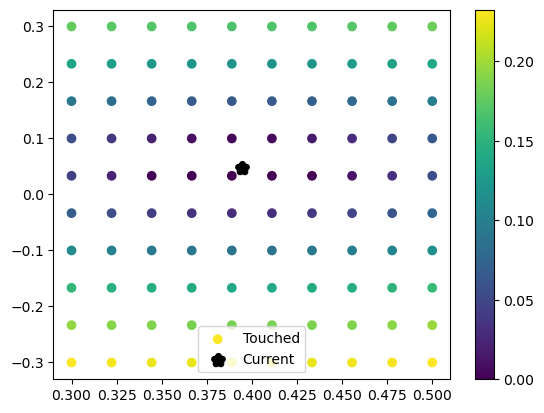

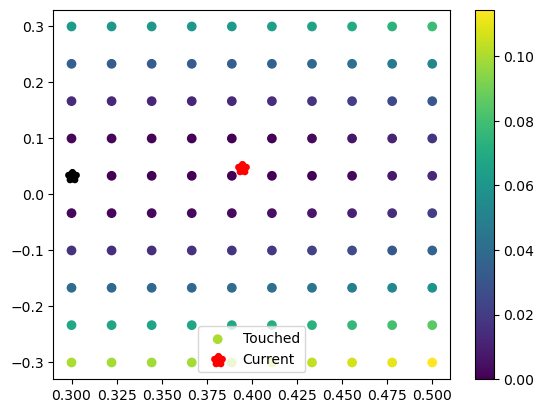

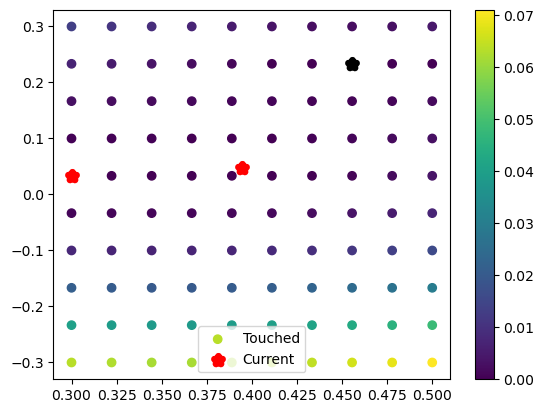

In [10]:
def run_search(station, frame = "iiwa_link_6"):
    plant = station.GetSubsystemByName("plant")
    # Get initial pose of the gripper by using default context of manip station.
    gripper = plant.GetBodyByName(frame)
    plant_context = plant.GetMyContextFromRoot(context)
    X_robot_W = plant.EvalBodyPoseInWorld(plant_context, gripper)
    table_end_effector_poses = get_table_contact(X_robot_W)
    obj_touched, new_contacts = move_arm(station, context, table_end_effector_poses)
    if obj_touched == "table":
        table_height = new_contacts[0][2]
        tounced_point = new_contacts[np.random.choice(np.arange(len(new_contacts)))]
    else:
        print("Table not found")
        AssertionError()
    p_grid = {}
    all_touched_points = []
    i = 0
    while obj_touched == "table":
        if i > 30:
            break
        i += 1
        reset_arm()
        current_touch = tounced_point[:2]
        all_touched_points.append(current_touch)
        next_touch, p_grid = sample_new_target(current_touch, p_grid)
        next_point = [next_touch[0], next_touch[1], table_height]
        # print(next_point)
        end_effector_poses = interpolate_locations(tounced_point, next_point, X_robot_W)
        obj_touched, new_contacts = move_arm(station, context, end_effector_poses)
        tounced_point = copy.deepcopy(next_point)

        x = []
        y = []    
        z = []
        for coord, prob in p_grid.items():
            x.append(coord[0])
            y.append(coord[1])
            z.append(prob)
        plt.scatter(x, y, c=z)
        plt.colorbar()
        # show the touched point with a star
        for i, t in enumerate(all_touched_points):
            if i < len(all_touched_points) - 1:
                plt.scatter(t[0], t[1], marker="*", c="red", linewidths=5)
            else:
                plt.scatter(t[0], t[1], marker="*", c="black", linewidths=5)
        # legend the two star points
        plt.legend(["Touched", "Current"])
        plt.show()

run_search(station)

In [11]:
reset_arm()

In [10]:
simulator = Simulator(station)
context = simulator.get_mutable_context()
x0 = station.GetOutputPort("iiwa+allegro.state_estimated").Eval(context)
station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)
simulator.AdvanceTo(0.1)
contact = station.GetOutputPort("contact_results").Eval(context)
num_contacts = contact.num_point_pair_contacts()
num_contacts


0

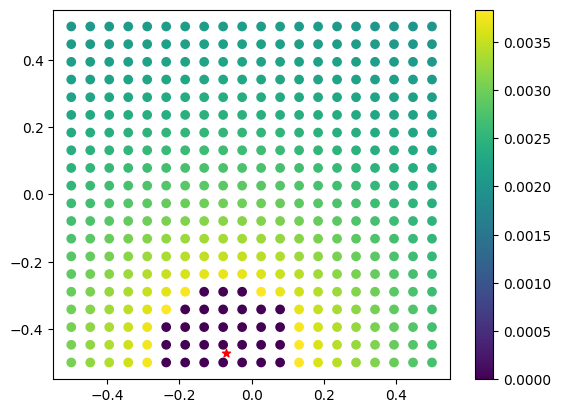

In [ ]:
object_r = 0.2
effort_ratio = 0.7
effort_c = 2.0
p_target_c = 2.0

table_x_bounds = [-0.5, 0.5]
table_y_bounds = [-0.5, 0.5]
n_samples = 20
table_grid = {}
for x in np.linspace(table_x_bounds[0], table_x_bounds[1], n_samples):
    for y in np.linspace(table_y_bounds[0], table_y_bounds[1], n_samples):
        table_grid[(x, y)] = 0.5
touched_point = np.random.rand(2) - 0.5
for coord, prob in table_grid.items():
    dist = np.linalg.norm(np.array(coord) - touched_point)
    if dist < object_r:
        table_grid[coord] = 0.0
    else:
        c_dist = dist - object_r
        effort_cost = np.exp(-effort_c * c_dist)
        p_target = 1 - np.exp(-p_target_c * c_dist)
        table_grid[coord] = effort_ratio * effort_cost + (1 - effort_ratio) * p_target
# normalize the table grid
table_grid_sum = sum(table_grid.values())
for coord, prob in table_grid.items():
    table_grid[coord] = prob / table_grid_sum
# plot the heatmap of the table grid
x = []
y = []
z = []
for coord, prob in table_grid.items():
    x.append(coord[0])
    y.append(coord[1])
    z.append(prob)
plt.scatter(x, y, c=z)
plt.colorbar()
# show the touched point with a star
plt.scatter(touched_point[0], touched_point[1], marker="*", c="red")
plt.show()


In [ ]:
start = np.array([0, 0, 0])
end = np.array([2, 0, 0])
new_locs = interpolate_locations(start, end)

In [ ]:
final_rotation = X_robot_W.rotation()
initial_position = X_robot_W.translation()
final_position = copy.deepcopy(initial_position)
final_position[2] = -0.2
# linearly interpolate between initial and final position

num_knot_points = 10
t_list = np.arange(num_knot_points)
positions = np.zeros((num_knot_points, 3))
for i in range(3):
    positions[:, i] = np.linspace(
        initial_position[i], final_position[i], num_knot_points
    )
p_list = []
for p in positions:
    p_list.append(RigidTransform(final_rotation, p))

In [ ]:
def create_q_knots(pose_lst):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant = station.GetSubsystemByName("plant")
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName(frame)
    iiwa_initial = np.array([0.0, 0.1, 0.0, -1.5, 0.0, 0.0, 0.0])
    gripper_initial = np.ones((23))
    q_nominal = np.hstack((iiwa_initial, gripper_initial))
    # q_nominal = iiwa_initial
    print(q_nominal.shape)

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        print(ik)
        # q_variables = ik.q()  # Get variables for MathematicalProgram
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        pose = pose_lst[i]
        AddPositionConstraint(
                    ik,
                    pose.translation() + 0.01,
                    pose.translation() + 0.01,
        )

        # AddOrientationConstraint(
        #     ik,
        #     pose.rotation(),
        #     0.02,
        # )
        
        prog.AddQuadraticErrorCost(np.identity(len(q_variables)), q_nominal, q_variables)
        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[i-1])

        result = Solve(prog)

        assert result.is_success()
        q_knots.append(result.GetSolution(q_variables))

    return q_knots

In [ ]:
# q_knots = np.array(create_q_knots(pose_lst))
# q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)
q_knots = np.array(create_q_knots(p_list))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_list, q_knots.T)

(30,)


In [ ]:
def move_hand(station, context, end_point):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    current_state[:end_point.shape[0]] = end_point
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [ ]:
contact = station.GetOutputPort("contact_results").Eval(context)
init_num_contacts = contact.num_point_pair_contacts()
contact_pre_move = []
for i in range(init_num_contacts):
    contact_pre_move.append(contact.point_pair_contact_info(i).contact_point())
print(contact_pre_move)

[]


In [ ]:
reset_arm()

NameError: name 'reset_arm' is not defined

In [ ]:
def get_contacts(station, context):
    contacts = []
    contact = station.GetOutputPort("contact_results").Eval(context)
    num_contacts = contact.num_point_pair_contacts()
    for i in range(num_contacts):
        contacts.append(contact.point_pair_contact_info(i).contact_point())
    return contacts

In [ ]:
all_q = q_knots[:, :7]
for each_q in all_q:
    move_hand(station, context, each_q)
    time.sleep(0.1)
    simulator.AdvanceTo(simulator.get_context().get_time() + 0.06)
    contact = station.GetOutputPort("contact_results").Eval(context)
    num_contacts = contact.num_point_pair_contacts()
    if num_contacts != init_num_contacts:
        print("contact changed")
        for i in range(num_contacts):
            print(contact.point_pair_contact_info(i).contact_point())        

contact changed
[ 4.46331316e-01 -5.02037940e-02 -6.46337134e-05]
[ 0.4547655   0.12516946 -0.00062631]
[ 0.45463158  0.12616688 -0.00063569]


In [ ]:
dir(contact.point_pair_contact_info(i))

['__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_pybind11_del_orig',
 'bodyA_index',
 'bodyB_index',
 'contact_force',
 'contact_point',
 'point_pair',
 'separation_speed',
 'slip_speed']

In [ ]:
contact = station.GetOutputPort("contact_results").Eval(context)
num_contacts = contact.num_point_pair_contacts()
contact_post_move = []
for i in range(num_contacts):
    # if contact.point_pair_contact_info(i).contact_point() not in contact_pre_move:
    contact_post_move.append(contact.point_pair_contact_info(i).contact_point())
    print(contact_post_move[i])



[ 0.63301612  0.03997491 -0.00141454]
[ 0.66179362  0.04264613 -0.00169813]
[ 0.6606545  0.0561385 -0.0026543]
[ 0.63392196 -0.01359524 -0.00210071]
[ 0.66282136 -0.0135821  -0.00242399]
[ 6.62949092e-01  1.67814952e-04 -3.52434867e-03]
[ 0.6329604  -0.03983164 -0.00147476]
[ 0.6617242  -0.04264438 -0.00176381]
[ 0.66051178 -0.05621701 -0.00277842]


In [ ]:
reset_arm()

In [ ]:
reset_arm()
allegro_state = plant.GetOutputPort("allegro_generalized_contact_forces").Eval(plant_context)
print("Pre-Movement Allegro contact: \n", allegro_state)

state = x0.copy()
state[1] = 1.3
state[5] = 1

allegro.set_positions(["index_"])
allegro.set_state(state, context)
simulator.AdvanceTo(context.get_time() + 1)

allegro_state = plant.GetOutputPort("allegro_generalized_contact_forces").Eval(plant_context)
print("\nPost-Movement contact: \n", allegro_state)

Pre-Movement Allegro contact: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Post-Movement contact: 
 [ 1.42691384e-03 -8.38035039e+00 -4.29735865e+00 -1.21253755e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.80283314e-03 -1.07918749e+01 -5.56614946e+00 -1.60781418e+00
  4.31904540e-04 -7.79119499e+00 -4.05517254e+00 -1.21517910e+00]


In [ ]:
get_contacts(station, context)

[array([0.76904282, 0.01331116, 0.04211101]),
 array([0.77095749, 0.01331137, 0.04206761]),
 array([0.82453812, 0.01332492, 0.04348466]),
 array([ 0.75905849, -0.02447317, -0.0011354 ]),
 array([ 0.8337264 ,  0.02477568, -0.00110502]),
 array([ 0.83355805, -0.02522403, -0.00111421]),
 array([ 0.75872882,  0.0250284 , -0.00137816]),
 array([ 0.75856046, -0.02497131, -0.00138735])]

In [ ]:
time = 0.2

In [ ]:
station.GetInputPort("iiwa+allegro.desired_state").Eval(context)[:7]

array([ 0. ,  0.1,  0. , -1.5,  0. ,  0. ,  0. ])

In [ ]:
def open_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    iiwa_idx = 7
    current_state[8] = 4
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [ ]:
def close_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    iiwa_idx = 7
    current_state[8] = 0
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [ ]:
allegro_map = {
    "index_revolute": 7,
    "index_0": 8,
    "index_1": 9,
    "index_2": 10,
    "thumb_": 11,
    "thumb_1": 12, 
    "thumb_revolute_z": 11,
    "thumb_revolute_y": 12, # avoid
    "thumb_joint_1": 13,
    "thumb_joint_2": 14,
    "middle_revolute": 15,
    "middle_0": 16,
    "middle_1": 17,
    "middle_2": 18,
    "pinky_revolute": 19,
    "pinky_0": 20,
    "pinky_1": 21,
    "pinky_2": 22
}

In [ ]:
def reset_hand(station, context):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    current_state[7:] = 0
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

In [ ]:
def move_finger(station, context, index, amount):
    current_state = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
    current_state[index] = amount
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, current_state)

index = 22
amount = 2

reset_hand(station, context)
simulator.AdvanceTo(time) 
time += 1

move_finger(station, context, index, amount)
simulator.AdvanceTo(time)
time += 1

In [ ]:
open_hand(station, context)
simulator.AdvanceTo(time)
time += 1

In [ ]:
close_hand(station, context)
simulator.AdvanceTo(time)
time += 1

In [ ]:
plant.get_contact_model()

<ContactModel.kHydroelasticWithFallback: 2>

In [ ]:
contact = station.GetOutputPort("contact_results").Eval(context)
num_contacts = contact.num_point_pair_contacts()
print(num_contacts)
a = contact.point_pair_contact_info(1)
a.contact_point()

8


array([ 7.20192680e-01,  1.15709952e-01, -5.80416268e-05])

[0.76671662 0.15635648 0.029096  ]
[ 7.20192680e-01  1.15709952e-01 -5.80416268e-05]
[0.80215838 0.10720572 0.02441489]
[ 7.95898018e-01  9.72281132e-02 -2.13457851e-04]
[ 6.37500001e-01  2.50000016e-02 -7.61718707e-06]
[ 6.37500002e-01 -2.49999973e-02 -1.28237572e-05]
[ 5.62500002e-01  2.50000026e-02 -1.28237666e-05]
[ 5.62500003e-01 -2.49999963e-02 -1.80303367e-05]


In [ ]:
end_effector_frame = station.